### MOPSO-CS

Training set shape: (800, 7)
Testing set shape: (200, 7)


100%|██████████| 1000/1000 [01:01<00:00, 16.13it/s]



Training Data Results:
Accuracy: 0.7888
Misclassification Number: 169
Misclassification Number (MCN): 95.9
Sum of Misclassified Differences (SMD): 114.74348126194842
Sum of Correct Differences (SCD): 322.42642866585913

Test Data Results:
Accuracy: 0.7600
Misclassification Number: 48
Misclassification Number (MCN): 29.6
Sum of Misclassified Differences (SMD): 29.450583155232792
Sum of Correct Differences (SCD): 76.73149147678143

Confusion Matrix:
[[50 17]
 [50 83]]
Specificity: 0.7463
Sensitivity: 0.6241


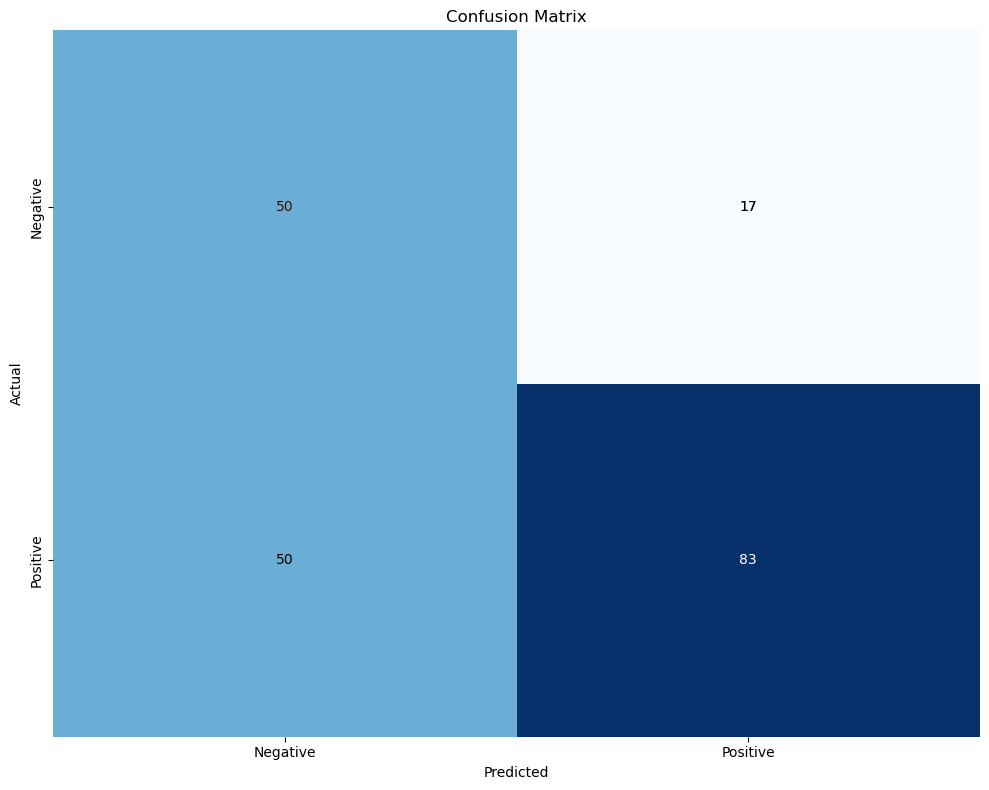


Number of misclassified instances: 67

Some misclassified examples:
Index: 3, Actual: 1, Predicted: 0, Probability: 0.0018
Index: 5, Actual: 0, Predicted: 1, Probability: 0.7958
Index: 13, Actual: 0, Predicted: 1, Probability: 0.9167
Index: 15, Actual: 1, Predicted: 0, Probability: 0.2143
Index: 16, Actual: 1, Predicted: 0, Probability: 0.1752


In [1]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')


np.random.seed(15)

data = pd.read_csv(r'C:/Users/corne/OneDrive/Documents/universiteit/Honeurs/Research/german_credit.csv')
data.columns = [col.replace(' ', '.') for col in data.columns]



def clean_column_name(name):
    return re.sub(r'[^\w]', '.', name)

data.columns = [clean_column_name(col) for col in data.columns]

def preprocess_data(data):

    variables = ['Account.Balance', 'Duration.of.Credit..month.', 'Payment.Status.of.Previous.Credit', 
                 'Sex...Marital.Status', 'Value.Savings.Stocks', 'Creditability', 'Credit.Amount', 'Instalment.per.cent']
    
    data = data[variables]

    # data['Account.Balance'] = data['Account.Balance'].replace(4, 3)
    # data['Payment.Status.of.Previous.Credit'] = data['Payment.Status.of.Previous.Credit'].replace({0: 1, 1: 1, 2: 2, 3: 3, 4: 3})
    # data['Purpose'] = data['Purpose'].replace({0: 4, 1: 1, 2: 2, 3: 3, 4: 3, 5: 3, 6: 3, 7: 4, 8: 4, 9: 4, 10: 4})
    # data['Value.Savings.Stocks'] = data['Value.Savings.Stocks'].replace({4:3,5:4})
    # data['Length.of.current.employment'] = data['Length.of.current.employment'].replace({2:1,3:2,4:3,5:4})
    # data['Sex...Marital.Status'] = data['Sex...Marital.Status'].replace({2:1,3:2,4:3})
    # data['No.of.Credits.at.this.Bank'] = data['No.of.Credits.at.this.Bank'].replace({3:2,4:2})
    # data['Guarantors'] = data['Guarantors'].replace({3:2,4:2})
    # data['Concurrent.Credits'] = data['Concurrent.Credits'].replace({2:1,3:2})

    X = data.drop('Creditability', axis=1)
    y = data['Creditability']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # scaler = MinMaxScaler(feature_range=(0,1))
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train) #standardise the data
    X_test_scaled = scaler.fit_transform(X_test)
    
    
    return X_train_scaled, X_test_scaled, y_train, y_test

class Particle:
    def __init__(self, dim):
        self.position = np.random.uniform(-3, 3, dim)
        self.velocity = np.random.uniform(-3, 3, dim)
        self.best_position = self.position.copy()
        self.fitness = float('inf')
        self.best_fitness = float('inf')
        self.rank = float('inf')
        self.mcn = float('inf')
        self.smd = float('inf')
        self.scd = float('inf')

class MOPSO_CS:
    def __init__(self, n_particles, dim, max_iter, cutoff = 0.05):
        self.n_particles = n_particles
        self.dim = dim
        self.max_iter = max_iter
        self.subswarm1 = [Particle(dim) for _ in range(n_particles)]
        self.subswarm2 = [Particle(dim) for _ in range(n_particles)]
        self.gbest1 = None
        self.gbest2 = None
        self.cutoff = cutoff

    def fitness(self, position, X, y, wG=0.3, wB=0.7):
      y_pred = 1 / (1 + np.exp(-np.dot(X, position)))
      y_pred_binary = (y_pred > self.cutoff).astype(int)

      misclassifications = np.sum(y != y_pred_binary)
    
      dG = ((y == 1) & (y_pred_binary == 0)).astype(int)
      dB = ((y == 0) & (y_pred_binary == 1)).astype(int)
    
      mcn = np.sum(wG * dG + wB * dB)
      smd = np.sum(np.abs(y_pred - y)[y != y_pred_binary])
      scd = np.sum(np.abs(y_pred - 0.05)[y == y_pred_binary])
    
      return misclassifications, mcn, smd, scd

    def update_velocity_position(self, particle, gbest, w=0.6, c1=1, c2=1):
        r1, r2 = np.random.rand(2)
        particle.velocity = (w * particle.velocity +
                             c1 * r1 * (particle.best_position - particle.position) +
                             c2 * r2 * (gbest - particle.position))
        particle.position += particle.velocity
        particle.position = np.clip(particle.position, -100, 100)

    def optimize(self, X, y):
     for _ in tqdm(range(self.max_iter)):
        for particle in self.subswarm1 + self.subswarm2:
            misclassifications, mcn, smd, scd = self.fitness(particle.position, X, y)
            particle.mcn = mcn
            particle.smd = smd
            particle.scd = scd
            particle.rank = 1 + misclassifications

            if mcn < particle.best_fitness:
                particle.best_fitness = mcn
                particle.best_position = particle.position.copy()

        sorted_particles = sorted(self.subswarm1 + self.subswarm2, 
                                  key=lambda p: (p.rank, p.smd, -p.scd))

        self.gbest1 = sorted_particles[0].position
        self.gbest2 = sorted_particles[1].position

        for particle in self.subswarm1:
            self.update_velocity_position(particle, self.gbest1)
        for particle in self.subswarm2:
            self.update_velocity_position(particle, self.gbest2)

     best_particle = sorted_particles[0]
     return best_particle.position

if __name__ == "__main__":
    X_train, X_test, y_train, y_test = preprocess_data(data)

    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")

    mopso = MOPSO_CS(n_particles=40, dim=X_train.shape[1], max_iter=1000)
    best_solution = mopso.optimize(X_train, y_train)

    train_misclassifications, train_mcn, train_smd, train_scd = mopso.fitness(best_solution, X_train, y_train)
    train_accuracy = 1 - train_misclassifications / len(y_train)

    test_misclassifications, test_mcn, test_smd, test_scd = mopso.fitness(best_solution, X_test, y_test)
    test_accuracy = 1 - test_misclassifications / len(y_test)

    print("\nTraining Data Results:")
    print(f"Accuracy: {train_accuracy:.4f}")
    print(f"Misclassification Number: {train_misclassifications}")
    print(f"Misclassification Number (MCN): {train_mcn}")
    print(f"Sum of Misclassified Differences (SMD): {train_smd}")
    print(f"Sum of Correct Differences (SCD): {train_scd}")

    print("\nTest Data Results:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Misclassification Number: {test_misclassifications}")
    print(f"Misclassification Number (MCN): {test_mcn}")
    print(f"Sum of Misclassified Differences (SMD): {test_smd}")
    print(f"Sum of Correct Differences (SCD): {test_scd}")

    y_pred_test = 1 / (1 + np.exp(-np.dot(X_test, best_solution)))
    y_pred_test_binary = (y_pred_test > 0.5).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred_test_binary)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    print(f"Specificity: {specificity:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'],
                cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    for i in range(2):
        for j in range(2):
            plt.text(j+0.5, i+0.5, conf_matrix[i, j],
                     ha="center", va="center", color="white" if conf_matrix[i, j] > 50 else "black")

    plt.tight_layout()
    plt.show()

    misclassified = y_test != y_pred_test_binary
    print("\nNumber of misclassified instances:", misclassified.sum())
    if misclassified.sum() > 0:
        print("\nSome misclassified examples:")
        misclassified_indices = np.where(misclassified)[0]
        for idx in misclassified_indices[:5]:
            print(f"Index: {idx}, Actual: {y_test.iloc[idx]}, Predicted: {y_pred_test_binary[idx]}, Probability: {y_pred_test[idx]:.4f}")

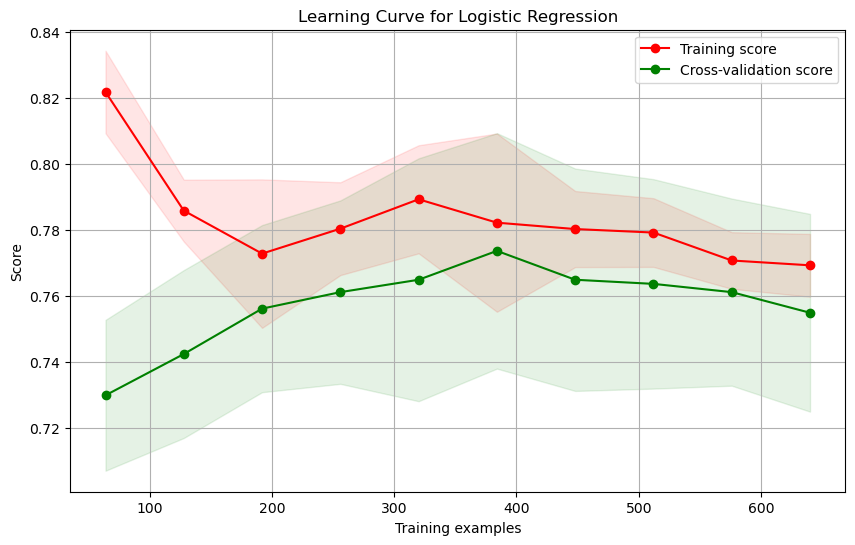

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curve(estimator, X, y, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

X_train, X_test, y_train, y_test = preprocess_data(data)
plot_learning_curve(classifier, X_train, y_train, title="Learning Curve for Logistic Regression")


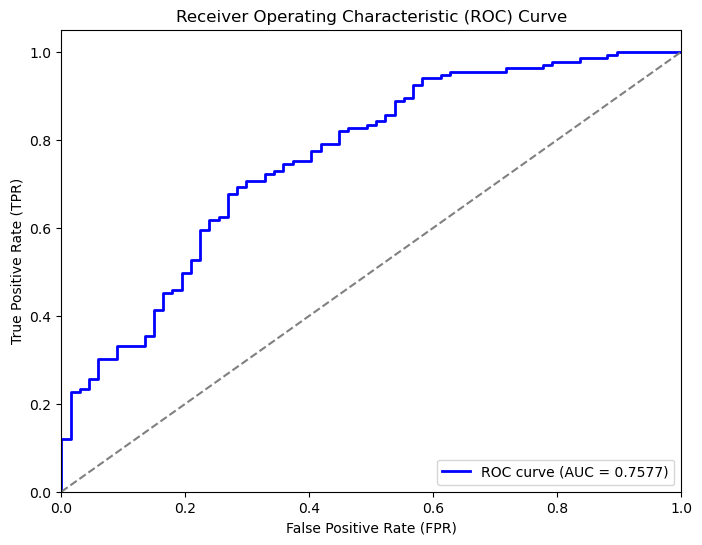

AUC: 0.7577


In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('ROC_MOPSO.pdf')
plt.show()

print(f"AUC: {roc_auc:.4f}")


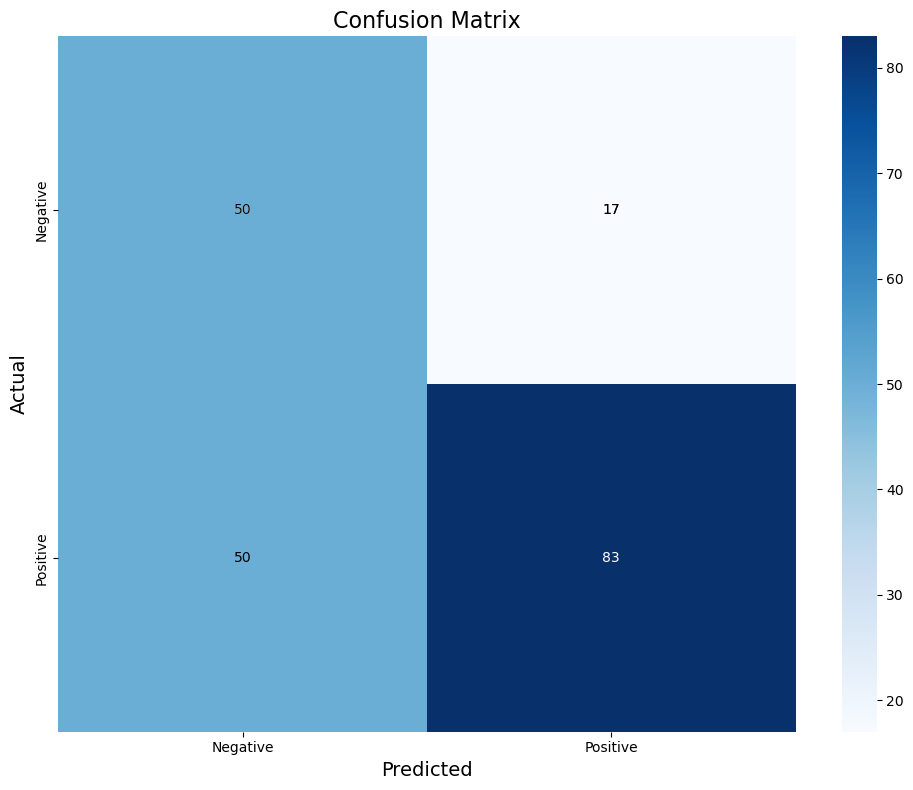

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'],
            cbar=True)  # Add color bar
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

for i in range(2):
    for j in range(2):
        plt.text(j+0.5, i+0.5, conf_matrix[i, j],
                 ha="center", va="center", color="white" if conf_matrix[i, j] > 50 else "black")

plt.tight_layout()
plt.savefig('ConfusionMatrix_MOPSO.pdf')
plt.show()


In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred_test_binary)

print(f"\nF1 Score: {f1:.4f}")



F1 Score: 0.7124


### Logistic Regression

In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# data = pd.read_csv(r'C:/Users/corne/OneDrive/Documents/universiteit/Honeurs/Research/german_credit.csv')

X = data.drop('Creditability', axis=1)
y = data['Creditability']

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

model = sm.Logit(y_train, X_train).fit()
print(model.summary())

p_values = model.pvalues
significant_vars = p_values[p_values <= 0.05].index
X_train_significant = X_train[significant_vars]
X_test_significant = X_test[significant_vars]

model_significant = sm.Logit(y_train, X_train_significant).fit()
print(model_significant.summary())


y_pred = model_significant.predict(X_test_significant)
y_pred_prob = model_significant.predict(X_test_significant)
y_pred = [1 if i > 0.5 else 0 for i in y_pred]

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

print(classification_report(y_test, y_pred))

Optimization terminated successfully.
         Current function value: 0.476282
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          Creditability   No. Observations:                  800
Model:                          Logit   Df Residuals:                      779
Method:                           MLE   Df Model:                           20
Date:                Sun, 24 Nov 2024   Pseudo R-squ.:                  0.2105
Time:                        16:43:37   Log-Likelihood:                -381.03
converged:                       True   LL-Null:                       -482.61
Covariance Type:            nonrobust   LLR p-value:                 2.645e-32
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -3.4214      1.105     -3